In [12]:
import torch
import cv2
import copy
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from open3d import JVisualizer
from pcdet.utils.calibration_kitti import get_calib_from_file

In [2]:
model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet101', pretrained=True)

Using cache found in /home/yzy/.cache/torch/hub/pytorch_vision_v0.8.0


In [3]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

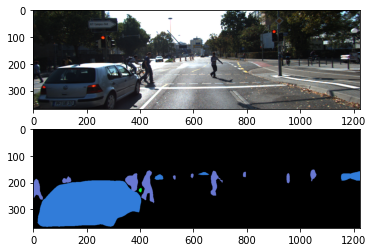

In [4]:
filename = "/home/yzy/PycharmProjects/OpenPCDet/data/kitti/training/image_2/005391.png"
image = Image.open(filename)
preprocess = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# inference
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_permute = output.permute(1,2,0)
output_probability, output_predictions =  output_permute.max(2)

# get mask
other_object_mask = ~((output_predictions == 0) | (output_predictions == 2) | (output_predictions == 7) | (output_predictions == 15))
detect_object_mask = ~other_object_mask
sf = torch.nn.Softmax(dim=2)

# bicycle = 2  car = 7 person = 15 background = 0
output_reassign = torch.zeros(output_permute.size(0),output_permute.size(1),4)
output_reassign[:,:,0] = detect_object_mask * output_permute[:,:,0] + other_object_mask * output_probability # background
output_reassign[:,:,1] = output_permute[:,:,2] # bicycle
output_reassign[:,:,2] = output_permute[:,:,7] # car
output_reassign[:,:,3] = output_permute[:,:,15] #person
output_reassign_softmax = sf(output_reassign)

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 3 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
select_objects = torch.where(detect_object_mask, output_predictions, 0)
r = Image.fromarray(select_objects.byte().cpu().numpy()).resize(image.size)
r.putpalette(colors)

fig, axes = plt.subplots(2,1)
axes[0].imshow(image)
axes[1].imshow(r)

In [9]:
# read lidar data
lidar_filename = '/home/yzy/PycharmProjects/OpenPCDet/data/kitti/training/velodyne/005391.bin'
lidar_raw = np.fromfile(lidar_filename, dtype=np.float32).reshape(-1,4)

# get calib
calib_file = '/home/yzy/PycharmProjects/OpenPCDet/data/kitti/training/calib/005391.txt'
calib = get_calib_from_file(calib_file)
calib['P2'] = np.concatenate([calib['P2'], np.array([[0., 0., 0., 1.]])], axis=0)
calib['P3'] = np.concatenate([calib['P3'], np.array([[0., 0., 0., 1.]])], axis=0)
calib['R0_rect'] = np.zeros([4, 4], dtype=calib['R0'].dtype)
calib['R0_rect'][3, 3] = 1.
calib['R0_rect'][:3, :3] = calib['R0']
calib['Tr_velo2cam'] = np.concatenate([calib['Tr_velo2cam'], np.array([[0., 0., 0., 1.]])], axis=0)

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(lidar_raw[..., :3])
o3d.visualization.draw_geometries([point_cloud],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [10]:
def create_cyclist(augmented_lidar):
    '''
    bicycle are people are segmented differently, combine them as cyclist
    '''
    bike_idx = np.where(augmented_lidar[:,5]>=0.2)[0] # 0, 1(bike), 2, 3(person)
    bike_points = augmented_lidar[bike_idx]
    cyclist_mask_total = np.zeros(augmented_lidar.shape[0], dtype=bool)
    for i in range(bike_idx.shape[0]):
        cyclist_mask = (np.linalg.norm(augmented_lidar[:,:3]-bike_points[i,:3], axis=1) < 1) & (np.argmax(augmented_lidar[:,-4:],axis=1) == 3)
        if np.sum(cyclist_mask) > 0:
            cyclist_mask_total |= cyclist_mask
        else:
            augmented_lidar[bike_idx[i], 4], augmented_lidar[bike_idx[i], 5] = augmented_lidar[bike_idx[i], 5], 0
    augmented_lidar[cyclist_mask_total, 7], augmented_lidar[cyclist_mask_total, 5] = 0, augmented_lidar[cyclist_mask_total, 7]
    return augmented_lidar

def cam_to_lidar(pointcloud, projection_mats):
    """
    Takes in lidar in velo coords, returns lidar points in camera coords
    :param pointcloud: (n_points, 4) np.array (x,y,z,r) in velodyne coordinates
    :return lidar_cam_coords: (n_points, 4) np.array (x,y,z,r) in camera coordinates
    """

    lidar_velo_coords = copy.deepcopy(pointcloud)
    reflectances = copy.deepcopy(lidar_velo_coords[:, -1]) #copy reflectances column
    lidar_velo_coords[:, -1] = 1 # for multiplying with homogeneous matrix
    lidar_cam_coords = projection_mats['Tr_velo2cam'].dot(lidar_velo_coords.transpose())
    lidar_cam_coords = lidar_cam_coords.transpose()
    lidar_cam_coords[:, -1] = reflectances

    return lidar_cam_coords

def augment_lidar_class_scores(class_scores, lidar_raw, projection_mats):
    """
    Projects lidar points onto segmentation map, appends class score each point projects onto.
    """
    lidar_cam_coords = cam_to_lidar(lidar_raw, projection_mats)
    lidar_cam_coords[:, -1] = 1 #homogenous coords for projection
    points_projected_on_mask = projection_mats['P2'].dot(projection_mats['R0_rect'].dot(lidar_cam_coords.transpose()))
    points_projected_on_mask = points_projected_on_mask.transpose()
    points_projected_on_mask = points_projected_on_mask/(points_projected_on_mask[:,2].reshape(-1,1))

    true_where_x_on_img = (0 < points_projected_on_mask[:, 0]) & (points_projected_on_mask[:, 0] < class_scores.shape[1]) #x in img coords is cols of img
    true_where_y_on_img = (0 < points_projected_on_mask[:, 1]) & (points_projected_on_mask[:, 1] < class_scores.shape[0])
    true_where_point_on_img = true_where_x_on_img & true_where_y_on_img

    points_projected_on_mask = points_projected_on_mask[true_where_point_on_img] # filter out points that don't project to image
    lidar_cam_coords = lidar_cam_coords[true_where_point_on_img]
    points_projected_on_mask = np.floor(points_projected_on_mask).astype(int) # using floor so you don't end up indexing num_rows+1th row or col
    points_projected_on_mask = points_projected_on_mask[:, :2] #drops homogenous coord 1 from every point, giving (N_pts, 2) int array

    #indexing oreder below is 1 then 0 because points_projected_on_mask is x,y in image coords which is cols, rows while class_score shape is (rows, cols)
    #socre dimesion: point_scores.shape[2] TODO!!!!
    point_scores = class_scores[points_projected_on_mask[:, 1], points_projected_on_mask[:, 0]].reshape(-1, class_scores.shape[2])
    augmented_lidar = np.concatenate((lidar_raw[true_where_point_on_img], point_scores), axis=1)
    augmented_lidar = create_cyclist(augmented_lidar)

    return augmented_lidar

lidar_painted = augment_lidar_class_scores(output_reassign_softmax, lidar_raw, calib)

In [13]:
np_points = np.array(lidar_painted[:,:3]) #xyz
np_color = np.array(lidar_painted[:,5:8])
point_cloud.points = o3d.utility.Vector3dVector(np_points)
point_cloud.colors = o3d.utility.Vector3dVector(np_color)
o3d.visualization.draw_geometries([point_cloud])

JVisualizer with 1 geometries